In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import xgboost
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
tf.executing_eagerly()

2.3.0


True

In [2]:
#Reading the data file
df = pd.read_csv('/content/musk_csv.csv')
df.head()

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,...,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96,1
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,...,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79,1
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,...,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39,1
3,4,MUSK-211,211_1+12,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,77,48,-34,46,-91,32,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-77,52,-41,-34,-32,-66,115,-7,-236,-60,-4,52,104,136,168,-60,-135,80,1
4,5,MUSK-211,211_1+13,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,78,48,-34,46,-91,31,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-76,52,-41,-34,-32,-66,115,-8,-236,-60,-4,52,104,137,168,-60,-135,80,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 170 entries, ID to class
dtypes: int64(168), object(2)
memory usage: 8.6+ MB


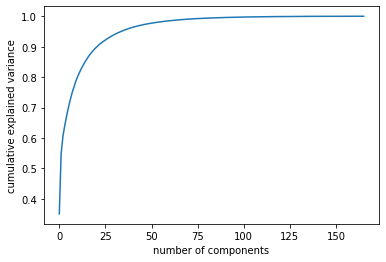

In [4]:
#Using PCA for dimensionality Reduction.
from sklearn.decomposition import PCA
pca = PCA().fit(df.drop(columns=['ID','molecule_name','conformation_name','class']))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

**For about 90% of the variance we will have to take 25 dimensions.**

In [5]:
#By observing cumulative explained variance graph, using 25 principal components is apt.
pca = PCA(n_components=25)
new_df = pca.fit_transform(df.drop(columns=['ID','molecule_name','conformation_name','class']))

In [6]:
#Importing split function and metrics.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_auc_score,precision_score,recall_score

X = new_df
Y = df['class']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state=12)

In [7]:
#Defining a function to print metrics.
def print_metrics(prediction, actual):
  print('accuracy_score:',accuracy_score(prediction, actual))
  print('confusion_matrix:\n',confusion_matrix(prediction,actual))
  print('f1_score:',f1_score(prediction,actual))
  print('roc_auc_score:',roc_auc_score(prediction,actual))
  print('precision_score:',precision_score(prediction,actual))
  print('recall_score:',recall_score(prediction,actual))

In [8]:
#Defining the ANN model using keras sequential api.
model = tf.keras.Sequential([
  layers.Dense(64, activation='relu', input_shape=(25,), kernel_regularizer=tf.keras.regularizers.l1(0.01)),
  layers.Dropout(0.1),
  layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
  layers.Dropout(0.1),
  layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
  layers.Dropout(0.05),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1664      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [9]:
#Compiling model.
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy','Precision','Recall','AUC'])

In [10]:
#Definig the early stopping callback.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [11]:
#Fitting the train data.
hist = model.fit(X_train, Y_train, batch_size=32,epochs=100, callbacks=callback, validation_data=(X_val, Y_val))

Epoch 1/100
165/165 [==============================] - 1s 5ms/step - loss: 11.3091 - accuracy: 0.8105 - precision: 0.3877 - recall: 0.3868 - auc: 0.6591 - val_loss: 6.5675 - val_accuracy: 0.9023 - val_precision: 0.7591 - val_recall: 0.5200 - val_auc: 0.8100
Epoch 2/100
165/165 [==============================] - 0s 2ms/step - loss: 7.2738 - accuracy: 0.8611 - precision: 0.5525 - recall: 0.5410 - auc: 0.7680 - val_loss: 5.7205 - val_accuracy: 0.8970 - val_precision: 0.6951 - val_recall: 0.5700 - val_auc: 0.8785
Epoch 3/100
165/165 [==============================] - 0s 2ms/step - loss: 6.1947 - accuracy: 0.8698 - precision: 0.5888 - recall: 0.5275 - auc: 0.8061 - val_loss: 5.3589 - val_accuracy: 0.9129 - val_precision: 0.7545 - val_recall: 0.6300 - val_auc: 0.9017
Epoch 4/100
165/165 [==============================] - 0s 2ms/step - loss: 5.5995 - accuracy: 0.8842 - precision: 0.6585 - recall: 0.5239 - auc: 0.8452 - val_loss: 5.1181 - val_accuracy: 0.9205 - val_precision: 0.8369 - val_reca

In [13]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


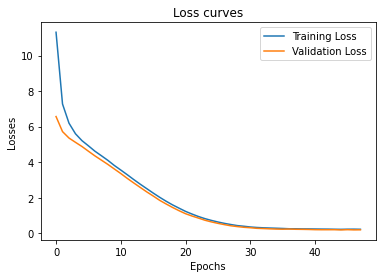

In [14]:
#Plotting the Loss graph.
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(('Training Loss','Validation Loss'))
plt.title('Loss curves')
plt.show()

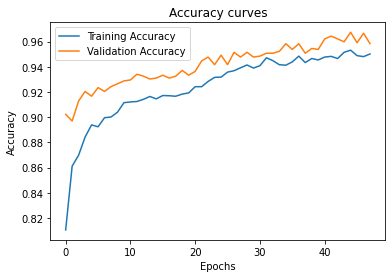

In [15]:
#Plotting the accuracy graph.
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(('Training Accuracy','Validation Accuracy'))
plt.title('Accuracy curves')
plt.show()

In [16]:
#Saving the model
model.save('ann1.h5')

In [17]:
#Prediction on the Validation data.
val_predicted = model(X_val)

In [19]:
#Rounding the prediction.
val_round = np.round(val_predicted)

In [21]:
#Printing the metrics.
print_metrics(val_round, Y_val)

accuracy_score: 0.9583333333333334
confusion_matrix:
 [[1112   47]
 [   8  153]]
f1_score: 0.8476454293628808
roc_auc_score: 0.9548791794168243
precision_score: 0.765
recall_score: 0.9503105590062112
